In [1]:
# import
%pylab inline
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

Populating the interactive namespace from numpy and matplotlib


## Question 1

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:

Which are the best universities in term of:       
(a) ratio between faculty members and students,     
(b) ratio of international students?       
Answer the previous question aggregating the data by      
(c) country and     
(d) region.

Plot your data using bar charts and describe briefly what you observed.

We define some variables we will use several times in the code.    
We then simply use a request to get the main page.

In [2]:
TOP_COUNT = 200
fac_members = 'fac_members'
inter_fac_members = 'inter_fac_members'
students = 'students'
inter_students = 'inter_students'
ratio_inter_students = 'ratio_inter_students'
country = 'country'
region = 'region'
ratio_fac_students = 'ratio_fac_students'

top_uni_json_link = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508402735534"
r = requests.get(top_uni_json_link)

We define a function to retrieve the number of students / faculty members given an url

In [3]:
def retrieve_people_number(url):
    div = 'div'
    data_carousel = 'academic-data-carousel'
    complete_url = "https://www.topuniversities.com/" + url
    r = requests.get(complete_url)
    
    soup = BeautifulSoup(r.text, 'html.parser') #Parse using BeautifulSoup
    
    numbers = soup.find(div, {'id':data_carousel})
    if (numbers==None): #If we can't find the data, we skip it
        print("error at : " + url)
        return None
    
    numbers = numbers.find_all(div, class_='number')
    
    #We remove the comma in the numbers
    numbers = list(map(lambda x: int(x.contents[0].replace('\n', '').replace(',', '')), numbers)) 
    if(len(numbers) == 4): 
        return numbers
    else:
        #If there isn't enough data, we perform some additional steps
        print("wrong number of elements at : " + url)
        #We find the h3 tags and find which ones are available
        h3s = soup.find(div, {'id':data_carousel}).find_all('h3') 
        h3s = list(map(lambda x: (x.contents[0].replace('\n', '').replace(',', '')), h3s))
        labels = ['Number of academic faculty staff','International','Number of students','Number of international students']
                
        result = [np.nan, np.nan, np.nan, np.nan]
        for h in range(0, len(h3s)):
            idx = labels.index(h3s[h])
            result[idx] = numbers[h]
        
        return result

We then create the DataFrame using the data from the main page, then populate a new DataFrame by iterating in the original DataFrame and retrieving the details for each university

In [4]:
top_uni_df = pd.DataFrame(r.json()['data']).head(TOP_COUNT)

missing_datas = pd.DataFrame(columns=[fac_members,inter_fac_members,students,inter_students])
for index, row in top_uni_df.iterrows(): 
    tmp = retrieve_people_number(row.url)
    if(tmp != None):
        missing_datas.loc[index] = tmp
    else: 
        missing_datas.loc[index] = [np.nan, np.nan, np.nan, np.nan]


error at : /universities/new-york-university-nyu
wrong number of elements at : /universities/indian-institute-science-iisc-bangalore


We then simply concatenate them and calculate the ratio faculty members/students and international students/students. We then drop the columns we won't need anymore.

In [5]:
def agg_by_and_calculate_ratio(df, byS, second):
    if (second):
        df=df[[byS,fac_members,students,inter_students]].groupby(by=[byS]).agg(sum)
    else:
        df=df[[byS,fac_members,inter_fac_members,students,inter_students]].groupby(by=[byS]).agg(sum)
    return calculate_ratio(df)

def calculate_ratio(df):
    df[ratio_fac_students] = df[fac_members].values / df[students]
    df[ratio_inter_students] = df[inter_students].values / df[students]
    return df

In [23]:
top_uni_df_complete = pd.concat([top_uni_df, missing_datas], axis=1)
top_uni_df_complete.drop(['cc','core_id', 'guide','logo','nid','score','stars','url'], axis=1, inplace=True)
top_uni_df_complete.rename(columns={'title': 'University'}, inplace=True)

calculate_ratio(top_uni_df_complete)

top_uni_df_complete.head()

,country,rank_display,region,University,fac_members,inter_fac_members,students,inter_students,ratio_fac_students,ratio_inter_students
0,United States,1,North America,Massachusetts Institute of Technology (MIT),2982,1679,11067,3717,0.26945,0.335863
1,United States,2,North America,Stanford University,4285,2042,15878,3611,0.26987,0.227422
2,United States,3,North America,Harvard University,4350,1311,22429,5266,0.193945,0.234785
3,United States,4,North America,California Institute of Technology (Caltech),953,350,2255,647,0.422616,0.286918
4,United Kingdom,5,Europe,University of Cambridge,5490,2278,18770,6699,0.292488,0.356899


We expect the USA and UK to have a big ratio of international students. We don't really have expectations for faculty members.

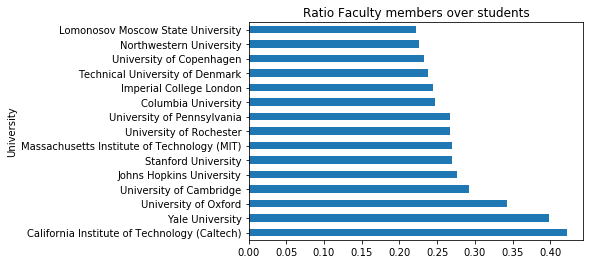

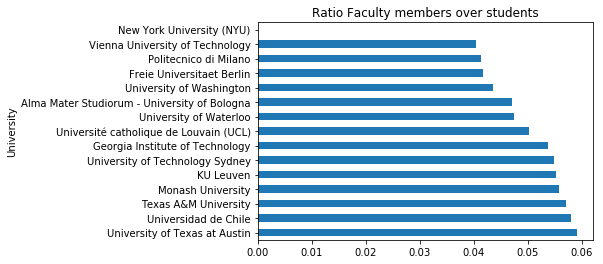

In [40]:
top_uni_df_complete.sort_values(ratio_fac_students, ascending=False).iloc[:15]\
    .plot(title='Ratio Faculty members over students', legend=False,x='University', y='ratio_fac_students', kind='barh')

top_uni_df_complete.sort_values(ratio_fac_students, ascending=False).iloc[-15:]\
    .plot(title='Ratio Faculty members over students', legend=False,x='University', y='ratio_fac_students', kind='barh')


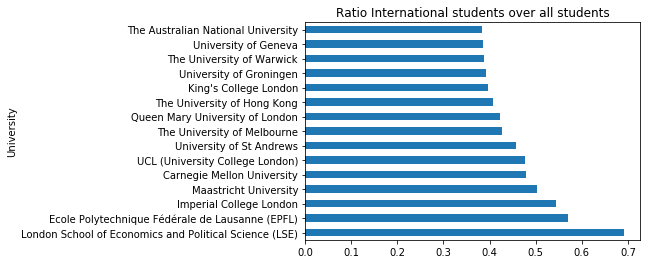

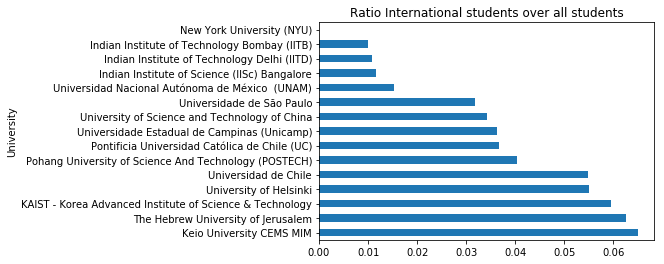

In [44]:
top_uni_df_complete.sort_values(ratio_inter_students, ascending=False).iloc[:15]\
    .plot(title='Ratio International students over all students', legend=False, x='University', y='ratio_inter_students', kind='barh')
top_uni_df_complete.sort_values(ratio_inter_students, ascending=False).iloc[-15:]\
    .plot(title='Ratio International students over all students', legend=False, x='University', y='ratio_inter_students', kind='barh')

Our assumption is mostly true, as 3 in the top 5 are universities from UK or USA. Also, EPFL is second place with 57% of international students.

We then aggregate by country, and then by region. We recalculate the ratios using the aggregated numbers, instead of doing a mean on the ratios (as that would be false, given that a small university could have a big ratio but shouldn't have a big impact on the total.)

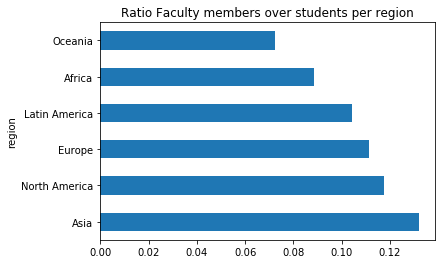

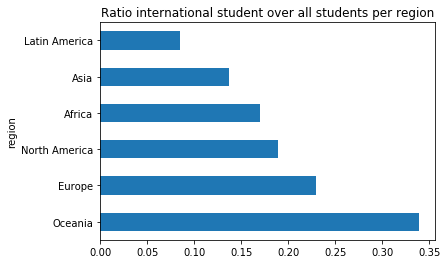

In [89]:
top_uni_df_complete_region = agg_by_and_calculate_ratio(top_uni_df_complete, region, False)

top_uni_df_complete_region.sort_values(ratio_fac_students,ascending=False)\
    .plot(title='Ratio Faculty members over students per region', legend=False, y='ratio_fac_students', kind='barh')
    
top_uni_df_complete_region.sort_values(ratio_inter_students,ascending=False)\
    .plot(title='Ratio international student over all students per region', legend=False, y='ratio_inter_students', kind='barh')

As expected, Europe and North America are in top 3, but Oceania is far ahead with 34%, which we didn't expect. That should be mostly due to Australia.

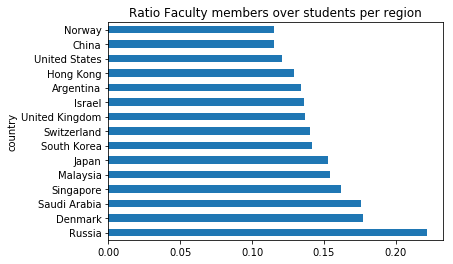

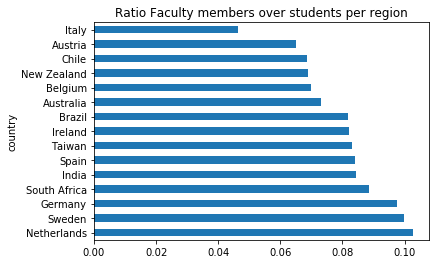

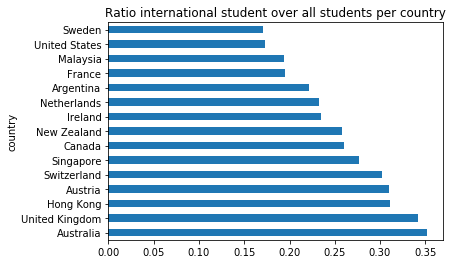

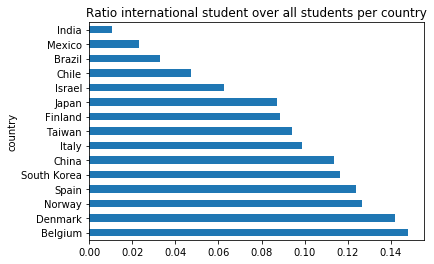

In [88]:
top_uni_df_complete_country = agg_by_and_calculate_ratio(top_uni_df_complete,country,False)

top_uni_df_complete_country.sort_values(ratio_fac_students,ascending=False).iloc[:15]\
    .plot(title='Ratio Faculty members over students per region', legend=False, y='ratio_fac_students', kind='barh')
    
top_uni_df_complete_country.sort_values(ratio_fac_students,ascending=False).iloc[-15:]\
    .plot(title='Ratio Faculty members over students per region', legend=False, y='ratio_fac_students', kind='barh')
    
top_uni_df_complete_country.sort_values(ratio_inter_students,ascending=False).iloc[:15]\
    .plot(title='Ratio international student over all students per country', legend=False, y='ratio_inter_students', kind='barh')
    
top_uni_df_complete_country.sort_values(ratio_inter_students,ascending=False).iloc[-15:]\
    .plot(title='Ratio international student over all students per country', legend=False, y='ratio_inter_students', kind='barh')

Indeed, looking at the ratio for international students, Australia is in first place. UK is close second, as expected, but USA is quite far down, which is a surprise. That's probably due to the difficulty to be accepted without an existing deal between an USA university and another. Switzerland is also notably fifth on the list.

## Question 2
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

We simply repeat the same process, although we don't have to make other requests to obtain the details.

In [102]:
stats_student_staff_ratio = 'stats_student_staff_ratio'
title_s = 'University'
times_high_json_link = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
r = requests.get(times_high_json_link)

In [103]:
times_high_df = pd.DataFrame(r.json()['data']).head(TOP_COUNT)

times_high_df = times_high_df[['location','aliases','name','rank','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']]
times_high_df.head()

,location,aliases,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,United Kingdom,University of Oxford,University of Oxford,1,"20,409",38%,11.2
1,United Kingdom,University of Cambridge,University of Cambridge,2,"18,389",35%,10.9
2,United States,California Institute of Technology caltech,California Institute of Technology,=3,"2,209",27%,6.5
3,United States,Stanford University,Stanford University,=3,"15,845",22%,7.5
4,United States,Massachusetts Institute of Technology,Massachusetts Institute of Technology,5,"11,177",34%,8.7


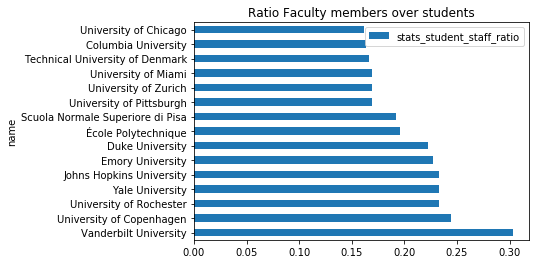

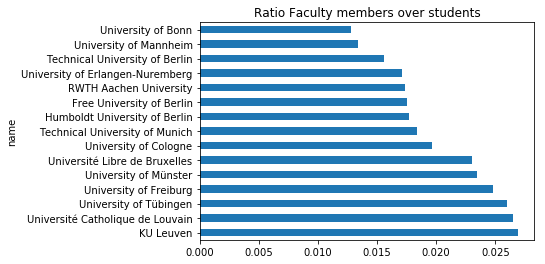

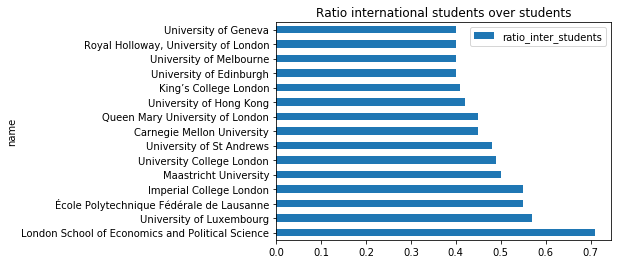

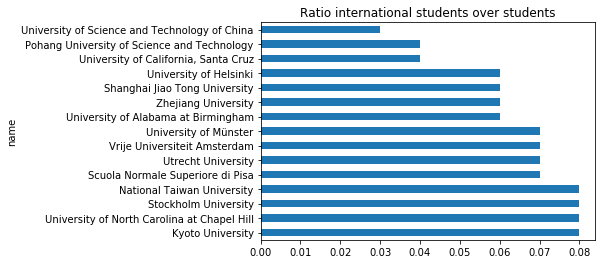

In [104]:
times_high_df[ratio_inter_students] = times_high_df['stats_pc_intl_students'].str.replace('%','').astype(int) / 100.0
times_high_df[stats_student_staff_ratio] = 1.0 / times_high_df[stats_student_staff_ratio].astype(float)

times_high_df.sort_values(by='stats_student_staff_ratio',ascending=False).iloc[:15]\
    .plot(title='Ratio Faculty members over students', legend=True,x='name', y='stats_student_staff_ratio', kind='barh')
times_high_df.sort_values(by='stats_student_staff_ratio',ascending=False).iloc[-15:]\
    .plot(title='Ratio Faculty members over students', legend=False,x='name', y='stats_student_staff_ratio', kind='barh')
    
times_high_df.sort_values(by=ratio_inter_students,ascending=False).iloc[:15]\
    .plot(title='Ratio international students over students', legend=True,x='name', y=ratio_inter_students, kind='barh')
times_high_df.sort_values(by=ratio_inter_students,ascending=False).iloc[-15:]\
    .plot(title='Ratio international students over students', legend=False,x='name', y=ratio_inter_students, kind='barh')

In [105]:
times_high_df[students] = times_high_df['stats_number_students'].astype(str).str.replace(',','').astype(int)
times_high_df[inter_students] = np.round(times_high_df[students] * times_high_df[ratio_inter_students]).astype(int)
times_high_df[fac_members] = np.round(times_high_df[students] * times_high_df[stats_student_staff_ratio]).astype(int)

We drop some useless columns and rename others.

In [109]:
times_high_df_complete = times_high_df.drop(['stats_pc_intl_students', 'aliases', 'stats_number_students'], axis=1)
times_high_df_complete.rename(columns = {stats_student_staff_ratio: ratio_fac_students, 'location': country,'name': title_s}, inplace=True)

We don't have the region in this case, therefore we only group by country. 

We expect roughly the same results as with the other website, obviously.

200


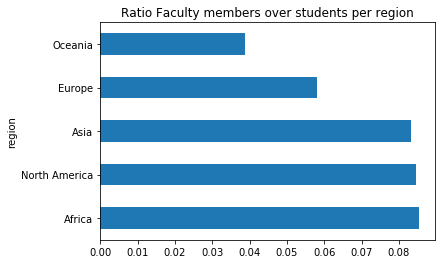

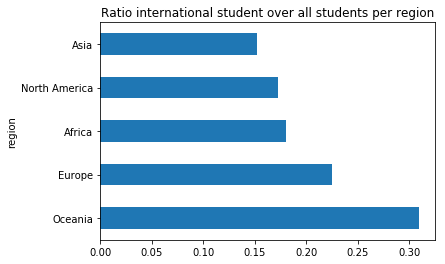

In [129]:
times_high_df_complete_region = times_high_df_complete.merge(top_uni_df_complete[['country', 'region']].drop_duplicates(), on='country', how='left')
times_high_df_complete_region.loc[times_high_df_complete_region.country == 'Luxembourg', 'region']='Europe'
times_high_df_complete_region.loc[times_high_df_complete_region.country == 'Russian Federation', 'region']='Asia'

times_high_df_complete_region = agg_by_and_calculate_ratio(times_high_df_complete_region, region, True)

times_high_df_complete_region.sort_values(ratio_fac_students,ascending=False)\
    .plot(title='Ratio Faculty members over students per region', legend=False, y='ratio_fac_students', kind='barh')
times_high_df_complete_region.sort_values(ratio_inter_students,ascending=False)\
    .plot(title='Ratio international student over all students per region', legend=False, y='ratio_inter_students', kind='barh')

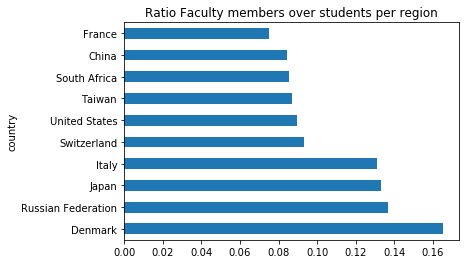

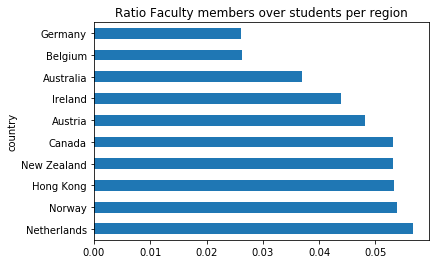

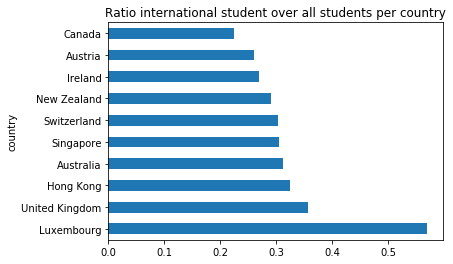

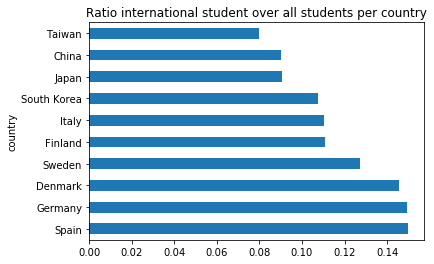

In [130]:
times_high_df_complete_country = agg_by_and_calculate_ratio(times_high_df_complete, country, True).sort_values(ratio_inter_students,ascending=False)

times_high_df_complete_country.sort_values(ratio_fac_students,ascending=False).iloc[:10]\
    .plot(title='Ratio Faculty members over students per region', legend=False, y='ratio_fac_students', kind='barh')
    
times_high_df_complete_country.sort_values(ratio_fac_students,ascending=False).iloc[-10:]\
    .plot(title='Ratio Faculty members over students per region', legend=False, y='ratio_fac_students', kind='barh')
    
times_high_df_complete_country.sort_values(ratio_inter_students,ascending=False).iloc[:10]\
    .plot(title='Ratio international student over all students per country', legend=False, y='ratio_inter_students', kind='barh')
    
times_high_df_complete_country.sort_values(ratio_inter_students,ascending=False).iloc[-10:]\
    .plot(title='Ratio international student over all students per country', legend=False, y='ratio_inter_students', kind='barh')

The results are indeed somewhat the same (some places are swapped), except for Luxembourg being first. Indeed, Luxembourg wasn't on the first website, which explains why we didn't expect this country being first at all.

## Question 3

Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.


We define a function to 'sanitize' a column and apply it to both dataframes.

We make both strings lowercase, remove common accents, translate some words (as a website stores the english name and the other the local name), remove words like "of, at, the" and "de", remove spaces and quotes.

We check by printing the difference of the outer and inner join if there are other patterns which make the names not match, apply it, check again, etc and do it iteratively.

In [131]:
def sanitize_column(c):
    return c.str.lower(). \
    str.replace('ä','a'). \
    str.replace('é','e'). \
    str.replace('freie','free'). \
    str.replace('universitat','university'). \
    str.replace('universitaet','university'). \
    str.replace('universidad', 'university'). \
    str.replace('universite','university'). \
    str.replace('technische','technical'). \
    str.replace(r'\(.*\)', ''). \
    str.replace('the ',''). \
    str.replace(' of ',''). \
    str.replace(' at ',''). \
    str.replace(' de ',''). \
    str.replace(r',|\.',''). \
    str.replace(' ',''). \
    str.replace('\'','’')

In [205]:
top_uni_bef_merge = top_uni_df_complete.copy()
top_uni_bef_merge[title_s] = sanitize_column(top_uni_bef_merge[title_s])

times_high_bef_merge = times_high_df_complete.copy()
times_high_bef_merge[title_s] = sanitize_column(times_high_bef_merge[title_s])

inner_title_s = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='inner').sort_values(title_s)[title_s]
outer_title_s = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='outer').sort_values(title_s)[title_s]
list_ = list(set(outer_title_s)-set(inner_title_s))
list_.sort()
pd.set_option('display.max_rows', None)
#print(str(outer_title_s[outer_title_s.isin(list_)]))
to_merge = [[87, 214], [9, 200], [119, 205], [123, 206]]
#print(len(list_))
#print('\n'.join(list_))
outered_df = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='outer').sort_values(title_s).fillna(0)
merge_df = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='inner').sort_values(title_s)

for couple in to_merge:
    to_add = outered_df.loc[couple[0]]
    to_add[10:] = outered_df.loc[couple[1], outered_df.columns[10:]]
    merge_df = merge_df.append(to_add, ignore_index=True)
                    
print(len(merge_df))                 

merge_df

146


/Users/antoinewehenkel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/antoinewehenkel/anaconda/lib/python3.6/site-packages/pandas/core/series.py:767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)


150


,country_x,rank_display,region,University,fac_members_x,inter_fac_members,students_x,inter_students_x,ratio_fac_students_x,ratio_inter_students_x,country_y,rank,ratio_fac_students_y,ratio_inter_students_y,students_y,inter_students_y,fac_members_y
0,Finland,=137,Europe,aaltouniversity,1257,370,12147,1831,0.103482,0.150737,Finland,190,0.049505,0.20,12744.0,2549.0,631.0
1,Denmark,119,Europe,aarhusuniversity,2316,602,26226,3762,0.0883093,0.143445,Denmark,=109,0.069930,0.12,25167.0,3020.0,1760.0
2,Australia,20,Oceania,australiannationaluniversity,1600,927,14442,5551,0.110788,0.384365,Australia,48,0.051813,0.35,15986.0,5595.0,828.0
3,United States,81,North America,bostonuniversity,3157,379,25662,7041,0.123022,0.274375,United States,=70,0.116279,0.25,24833.0,6208.0,2888.0
4,United States,53,North America,brownuniversity,1303,379,9251,1825,0.14085,0.197276,United States,=50,0.093458,0.20,8898.0,1780.0,832.0
5,United States,4,North America,californiainstitutetechnology,953,350,2255,647,0.422616,0.286918,United States,=3,0.153846,0.27,2209.0,596.0,340.0
6,United Kingdom,=137,Europe,cardiffuniversity,2755,705,24565,6090,0.112151,0.247914,United Kingdom,=162,0.074074,0.26,24186.0,6288.0,1792.0
7,United States,=47,North America,carnegiemellonuniversity,1342,425,13356,6385,0.100479,0.478062,United States,24,0.074074,0.45,12676.0,5704.0,939.0
8,Hong Kong,46,Asia,chineseuniversityhongkong,2208,1074,18037,4824,0.122415,0.26745,Hong Kong,58,0.057803,0.31,18072.0,5602.0,1045.0
9,Hong Kong,49,Asia,cityuniversityhongkong,1349,1027,9240,3273,0.145996,0.354221,Hong Kong,=119,0.089286,0.35,9240.0,3234.0,825.0


## Question 4

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

## Question 5

Can you find the best university taking in consideration both rankings? Explain your approach.
